# PCA of amplitude spectrum of LFP

One way to attempt to describe the differences in LFP when comparing different animals, or different regions of the BG, is using PCA. 

For this purpose, a very large set of LFP was used. Specifically, a large set of channels from STR and GP were collected. These were split into smaller epochs. Using DFT, the amplitude spectrum for some frequencies of these epochs were produced. PCA was then applied to this large set of amplitude spectrum epochs. 

This method produces a model to describe a lower-dimensional representation of a very large amount of possible LFP "states" in the patients. This enables a potentially more effective way of comparing different types of LFP.

## Implementation

Several software functinos were required to construct the model. These will be described in greater detail as they are used, for readability purposes.

In [1]:
cd ../utilities/

/home/gustav/Documents/DD142X/code/utilities


In [2]:
from features import ffv
from matlab_util import str_lfp, gp_lfp, has_str, has_gp
from plotting import rasterize, simultaneous_raster_withbounds

# For functionality of numpy, matplotlib, and sklearn, refer to their respective documentation.
import numpy as np                     # https://numpy.org/
import matplotlib.pyplot as plt        # https://matplotlib.org/
from sklearn.decomposition import PCA  # https://scikit-learn.org/stable/index.html

In [3]:
cd ../_data/matlabData

/home/gustav/Documents/DD142X/code/_data/matlabData


In [4]:
files = !ls
print(files)

['NPR040.c12.mat', 'NPR040.d12.mat', 'NPR052d.05.mat', 'NPR052e.10.mat', 'NPR064.b08.mat', 'NPR064.c09.mat', 'NPR065c.10.mat', 'NPR065e.03.mat', 'NPR-073.d04.mat', 'NPR-073.d08.mat', 'NPR-075.b11.mat', 'NPR-075.b13.mat', 'NPR-075.c013.mat', 'NPR-075.c08.mat', 'NPR-075.d07.mat', 'NPR-076.b05.mat', 'NPR-076.b09.mat', 'NPR-076.c09.mat', 'NPR-076.d07.mat', 'pjx289c.01.mat', 'pjx289e08.mat']


Epoch size was chosen to a somewhat arbitrary, but easily modifiable length. Sampling frequency for the data used in this project is 16 kHz. 

The functions `str_lfp` and `gp_lfp` return all channel data from STR and GP channels of a file from the dataset used in this project as a two-dimensional `numpy` array, respectively. The `ep` parameter trims values from the tails of the channel data to ensure that the channels are resizable into the appropriate epoch size. The `has_str` and `has_gp` functions are to ensure the existence of such data in a file (the code fails to execute otherwise). Here, the data is then reshaped into epochs and collected into the complete `str_epochs` and `gp_epochs` arrays, respectively.

The print statements show the time represented by a certain epoch size and sampling frequency, and the total amount of epochs collected.

In [5]:
# Epoch size
ep = 2 ** 12
# Sampling frequency
Fs = 16000
print("Epoch length = " + str(1000 * ep / Fs) + "ms")

str_epochs = np.concatenate([
    str_lfp(filename, ep).reshape((-1, ep)) 
    for filename in files
    if has_str(filename)
])

gp_epochs = np.concatenate([
    gp_lfp(filename, ep).reshape((-1, ep)) 
    for filename in files
    if has_gp(filename)
])

print(str_epochs.shape)
print(gp_epochs.shape)

Epoch length = 256.0ms
(65575, 4096)
(118153, 4096)


The next step is finding the amplitude spectrum of the epochs. This is the purpose of the `ffv` function. `ffv` is shorthand for "Fourier Feature Vector", a name of our choosing. 

The `amount_steps` variable is only for memory concerns. Attempting to use `ffv` on the entirety of our epoch set resulted in memory allocation issues. An attentive reader might notice that the use of this variable results in a few samples being lost. Due to the large amount of epochs available (>100 000), and the low amount of epochs lost due to integer rounding (<20), this was concidered inconsequential.

The `lo` and `hi` variables specify the bounds of the amplitude spectrum returned by `ffv`. With `lo = 5` and `hi = 45`, no part of the amplitude spectrum for frequencies >5 Hz or <45 Hz will be returned. These bounds were chosen somewhat arbitrarily to extend slightly beyond the beta-range frequencies.

The `fft_n` variable can be used to increase *fidelity*. In simple terms, a larger value for `fft_n` causes `ffv` to return an amplitude spectrum with amplitude samples for a greater amount of frequencies within specified bounds.

One thing to note is that `ffv` returns not only the amplitude spectrum for each row in the input, but also a list of frequencies. Specifically, if `spectrum, frequencies = ffv(...)`, and `frequencies[idx] = f` then `spectrum[row, idx]` is the amplitude for the frequency `f` for any epoch with index `row` in the input. 

In [6]:
amount_steps = 10
lo = 10
hi = 45
fft_n = 2 ** 13

incr_str = int(str_epochs.shape[0] / amount_steps)
incr_gp  = int( gp_epochs.shape[0] / amount_steps)

str_ffv = [ffv(
    str_epochs[idx * incr_str : (idx + 1) * incr_str],
    epoch_size = ep,
    lo = lo,
    hi = hi,
    fft_n = fft_n
) for idx in range(0, amount_steps)]
gp_ffv = [ffv(
    gp_epochs[idx * incr_gp : (idx + 1) * incr_gp],
    epoch_size = ep,
    lo = lo,
    hi = hi,
    fft_n = fft_n
) for idx in range(0, amount_steps)]

frqs = str_ffv[0][1]
print(frqs)

[11.71875  13.671875 15.625    17.578125 19.53125  21.484375 23.4375
 25.390625 27.34375  29.296875 31.25     33.203125 35.15625  37.109375
 39.0625   41.015625 42.96875  44.921875]


With the index-to-frequency mappings saved in `frqs`, `str_ffv` and `gp_ffv` epoch data is collected into a usable format.

In [7]:
n_features = len(frqs)
str_ffv = np.array([part for part, _ in str_ffv]).reshape((-1, n_features))
gp_ffv  = np.array([part for part, _ in  gp_ffv]).reshape((-1, n_features))
all_ffv = np.concatenate((str_ffv, gp_ffv), axis = 0)
print(str_ffv.shape)
print( gp_ffv.shape)
print(all_ffv.shape)

(65570, 18)
(118150, 18)
(183720, 18)


PCA is applied to `all_ffv`, and representations of `str_ffv`, `gp_ffv`, and `all_ffv` in terms of produced PC's are created. Some information regarding the effectiveness of the model is also printed.

In [8]:
n_components = 10
pca_model = PCA(n_components = n_components).fit(all_ffv.copy())

pcs_all = pca_model.transform(all_ffv.copy())
pcs_str = pca_model.transform(str_ffv.copy())
pcs_gp  = pca_model.transform( gp_ffv.copy())

for i in range(0, n_components):
    print("Component " + str(i) + " explains\t" + \
            str(round(100 * pca_model.explained_variance_ratio_[i], 2)) + "%\tvariance." + \
            "\tSum = " + str(pca_model.explained_variance_ratio_[:i + 1].sum())
         )

Component 0 explains	29.08%	variance.	Sum = 0.29081261697887884
Component 1 explains	12.04%	variance.	Sum = 0.4112589046271417
Component 2 explains	10.2%	variance.	Sum = 0.5132418021435623
Component 3 explains	7.98%	variance.	Sum = 0.5930238506857056
Component 4 explains	7.08%	variance.	Sum = 0.6638342386869471
Component 5 explains	6.53%	variance.	Sum = 0.7291167733607984
Component 6 explains	4.74%	variance.	Sum = 0.7764670914087252
Component 7 explains	4.1%	variance.	Sum = 0.8174802608875701
Component 8 explains	3.28%	variance.	Sum = 0.8502603135662823
Component 9 explains	2.93%	variance.	Sum = 0.8795557250130781


The first two components explain >50% of variance. It's interesting to visualize the epochs under this transform. The `rasterize` function takes a two-dimensional `numpy` array, and selects the first two elements of each row for visualization. The `rasterize` function does not show actual value bounds for the data being shown, the bounds are relative within the dataset. It should be used with care.

In [9]:
raster_all = rasterize(pcs_all)
raster_str = rasterize(pcs_str)
raster_gp  = rasterize(pcs_gp)
x1var, x2var = pca_model.explained_variance_ratio_[0:2]

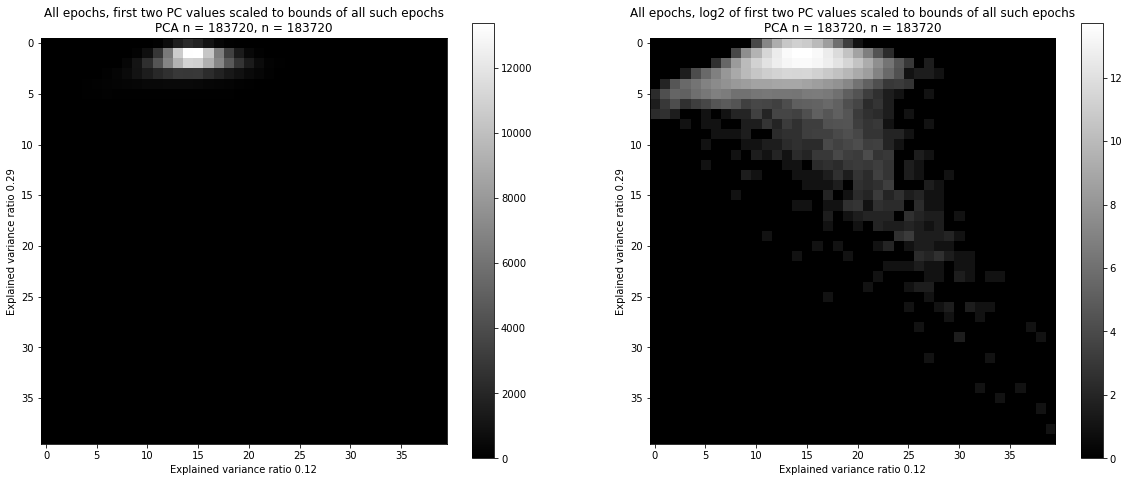

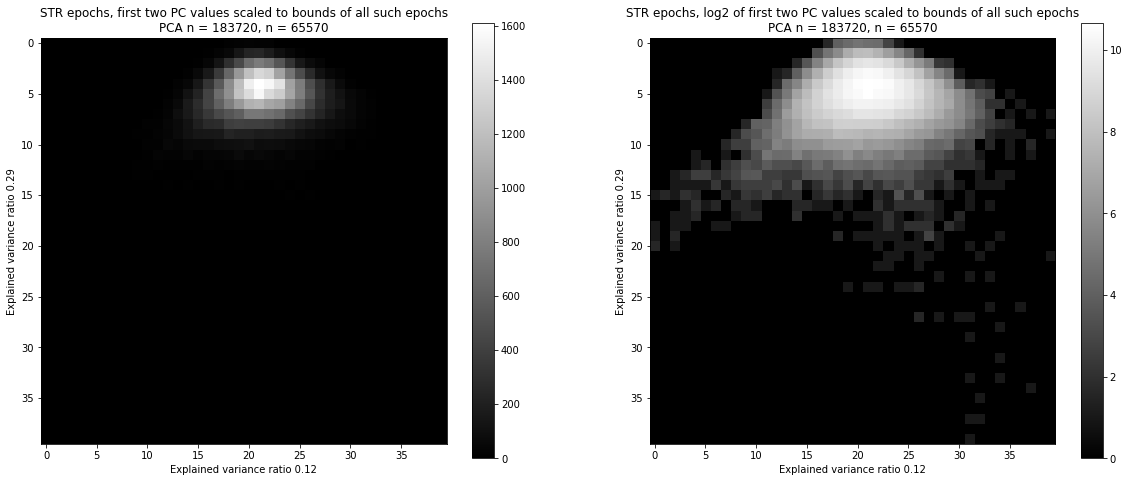

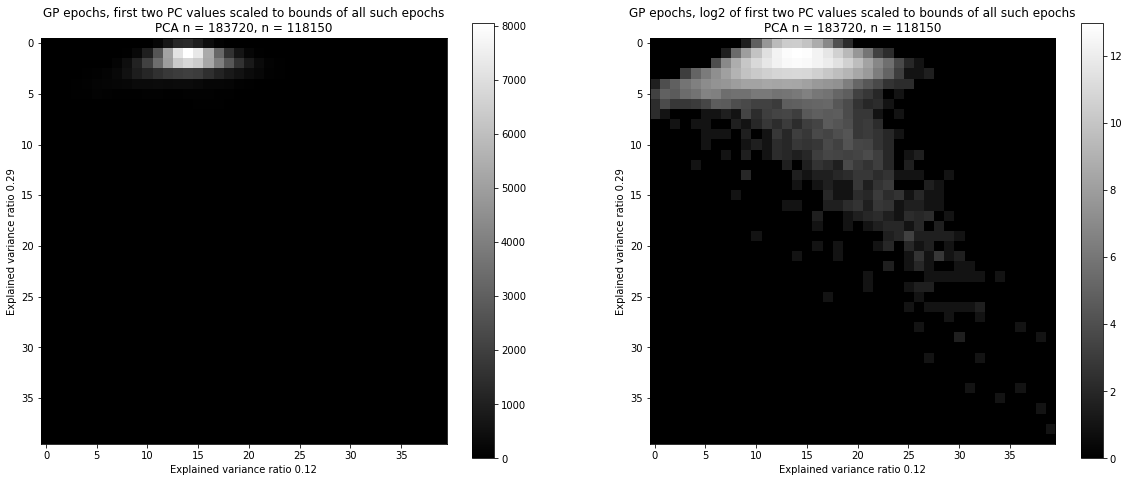

In [10]:
for raster, title_type, n_epochs in zip(
    [raster_all, raster_str, raster_gp],
    ["All epochs", "STR epochs", "GP epochs"],
    [all_ffv.shape[0], str_ffv.shape[0], gp_ffv.shape[0]]
):
    plt.figure(figsize = (20, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(raster, cmap = 'gray')
    plt.title(title_type + ", first two PC values scaled to bounds of all such epochs\n" + \
              "PCA n = " + str(all_ffv.shape[0]) + ", n = " + str(n_epochs))
    plt.xlabel("Explained variance ratio " + str(round(x2var, 2)))
    plt.ylabel("Explained variance ratio " + str(round(x1var, 2)))
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.log2(raster + 1), cmap = 'gray')
    plt.title(title_type + ", log2 of first two PC values scaled to bounds of all such epochs\n" + \
              "PCA n = " + str(all_ffv.shape[0]) + ", n = " + str(n_epochs))
    plt.xlabel("Explained variance ratio " + str(round(x2var, 2)))
    plt.ylabel("Explained variance ratio " + str(round(x1var, 2)))
    plt.colorbar()
    
    plt.show()

It is also possible to visualize STR and GP in the same image. Here a visualization where STR is shown in red and GP in blue is produced. In this example, the bounds are respected in the sense that their range is close to that of the original data.

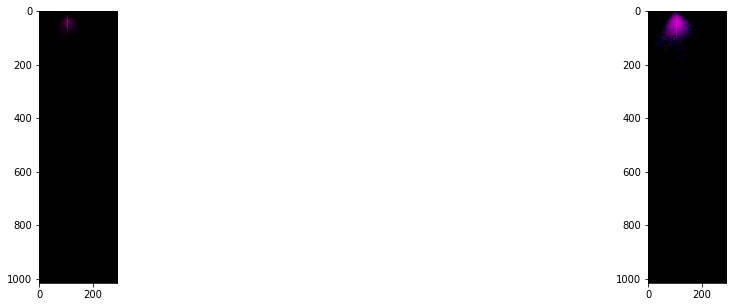

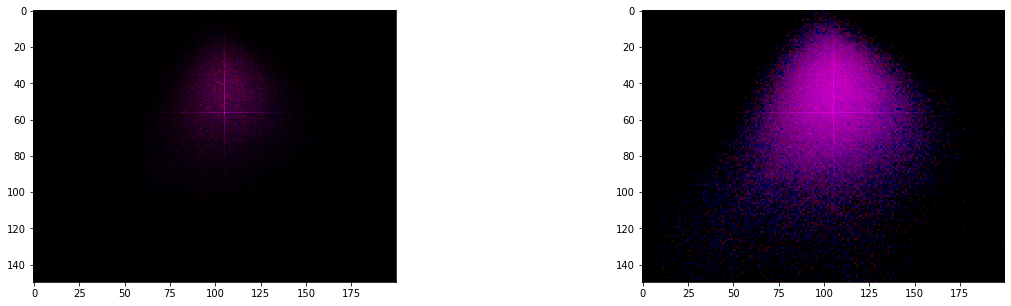

In [24]:
pcs_str_gp_raster, pcs_str_gp_raster_log2 = simultaneous_raster_withbounds(pcs_str, pcs_gp, True)
for raster in [pcs_str_gp_raster, pcs_str_gp_raster_log2]:
    raster[ : , : , 0] /= np.max(raster[ : , : , 0])
    raster[ : , : , 2] /= np.max(raster[ : , : , 2])

plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.imshow(pcs_str_gp_raster)
plt.subplot(1, 2, 2)
plt.imshow(pcs_str_gp_raster_log2)
plt.show()

plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.imshow(pcs_str_gp_raster[0 : 150, 0 : 200])
plt.subplot(1, 2, 2)
plt.imshow(pcs_str_gp_raster_log2[0 : 150, 0 : 200])
plt.show()

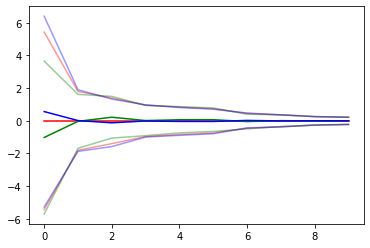

In [25]:
for pcs, c in zip(
    [pcs_all, pcs_str, pcs_gp],
    ['r', 'g', 'b']
):
    mean_ = pcs.mean(axis = 0)
    mad_ = np.abs(pcs - mean_).mean(axis = 0)
    mean_ *= pca_model.explained_variance_ratio_
    mad_ *= pca_model.explained_variance_ratio_
    plt.plot(mean_, c)
    plt.plot(mean_ + mad_, c, alpha = 0.4)
    plt.plot(mean_ - mad_, c, alpha = 0.4)
plt.show()

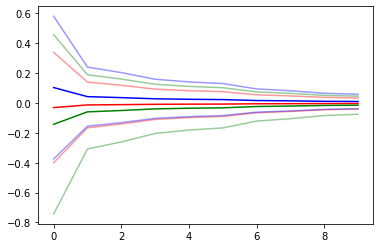

In [26]:
for animal, c in zip(
    ["NPR064.c09.mat", "NPR-075.b11.mat", "NPR065c.10.mat"],
    ['r', 'g', 'b']
):
    data = np.concatenate((
        str_lfp(animal, epoch_size = ep), gp_lfp(animal, epoch_size = ep)
    ), axis = 0)
    ffvs, _ = ffv(
        data,
        epoch_size=ep,
        lo = lo,
        hi = hi,
        fft_n = fft_n
    )
    pcs = pca_model.transform(ffvs.copy()).mean(axis = 0)
    mean_ = pcs.mean(axis = 0)
    mad_ = np.abs(pcs - mean_).mean(axis = 0)
    mean_ *= pca_model.explained_variance_ratio_
    mad_ *= pca_model.explained_variance_ratio_
    plt.plot(mean_, c)
    plt.plot(mean_ + mad_, c, alpha = 0.4)
    plt.plot(mean_ - mad_, c, alpha = 0.4)
plt.show()